In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM, CuDNNLSTM, Flatten, MaxPooling1D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, TimeDistributed, Conv1D, Conv2D
from tensorflow.keras.optimizers import Adam

In [2]:
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
from time import time

import os
import sys

In [3]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from label_transforms import *
from src.utils.train_test_split import train_test_split

In [5]:
path = "../../../files/out/low_level/video_data_low_level_A220.hdf5"
f = h5py.File(name=path, mode='r')
x = np.array(f['x'])
y = np.array(f['y'])

# Running on angry and happy

In [7]:
ang_idx = emotion_abr_to_emotion_id["ang"]
print("ang_idx:", ang_idx)
hap_idx = emotion_abr_to_emotion_id["hap"]
print("hap_idx:", hap_idx)

ang_idx: 12
hap_idx: 33


In [8]:
x_ang_hap = x[np.where((y == ang_idx) | (y == hap_idx))]
y_ang_hap = y[np.where((y == ang_idx) | (y == hap_idx))]

In [9]:
x_ang_hap_au04 = x_ang_hap[:, :, 2]

In [10]:
x_ang_hap_au04.shape

(16, 1084)

In [11]:
y_ang_hap.shape

(16,)

In [12]:
x_ang_au04 = x_ang_hap_au04[np.where(y_ang_hap == ang_idx)]

In [13]:
x_ang_au04.shape

(8, 1084)

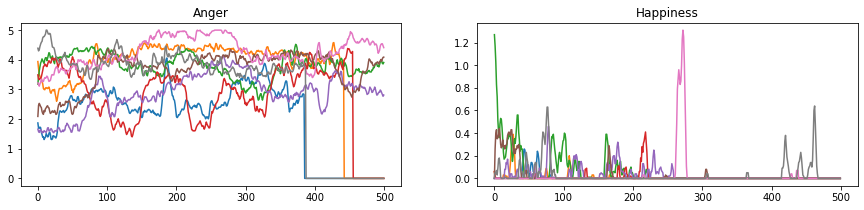

In [16]:
x_ang_au04 = x_ang_hap_au04[np.where(y_ang_hap == ang_idx)]
x_hap_au04 = x_ang_hap_au04[np.where(y_ang_hap == hap_idx)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
for vid_idx in range(8):
    axes[0].set_title("Anger")
    axes[1].set_title("Happiness")
    ts_ang = x_ang_au04[vid_idx, :500]
    ts_hap = x_hap_au04[vid_idx, :500]
    axes[0].plot(ts_ang)
    axes[1].plot(ts_hap)
plt.show()

In [19]:
y_ang_hap[y_ang_hap == ang_idx] = 0
y_ang_hap[y_ang_hap == hap_idx] = 1

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_ang_hap_au04, y_ang_hap, test_size = 0.3)

In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
seq_len=1084
STEPS = 50
EPOCHS= 60

NAME = f"td_suDB-{seq_len}seq_{int(time())}"
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

# model_d.add(Dropout(0.5))
# model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_d.add(Flatten())
# model_d.add(Dropout(0.5))
model_d.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))


model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1084, 100)         40800     
_________________________________________________________________
flatten (Flatten)            (None, 108400)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               10840100  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,881,001
Trainable params: 10,881,001
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_d.fit(X_train, y_train, batch_size=500, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
1/1 [==============================] - 5s 5s/step - loss: 0.6702 - accuracy: 0.4545 - val_loss: 0.1533 - val_accuracy: 0.8000
Epoch 2/60
1/1 [==============================] - 2s 2s/step - loss: 0.4691 - accuracy: 0.4545 - val_loss: 0.1050 - val_accuracy: 1.0000
Epoch 3/60
1/1 [==============================] - 2s 2s/step - loss: 0.3343 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 4/60
1/1 [==============================] - 2s 2s/step - loss: 0.1665 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 5/60
1/1 [==============================] - 2s 2s/step - loss: 0.0377 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 6/60
1/1 [==============================] - 2s 2s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.3349e-05 - val_accuracy: 1.0000
Epoch 7/60
1/1 [==============================] - 2s 2s/step - loss: 1.4146e-04 - accuracy: 1.0000 - val_loss: 1.0641e-06 - val_accuracy: 1.0000
Epoch 8/60
1/1 [=============

KeyboardInterrupt: 

In [29]:
np.round(model_d.predict(X_test))

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [28]:
y_test

array([0, 1, 0, 0, 0])

# Running on all emotions and action units

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [31]:
seq_len=1084
STEPS = 50
EPOCHS= 60

model_a = Sequential()

model_a.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model_a.add(Flatten())
model_a.add(Dense(100, activation='relu'))

model_a.add(Dense(44, activation='sigmoid'))


model_a.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1084, 100)         47200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 108400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10840100  
_________________________________________________________________
dense_3 (Dense)              (None, 44)                4444      
Total params: 10,891,744
Trainable params: 10,891,744
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_a.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 13s 2s/step - loss: 4.6753 - accuracy: 0.0488 - val_loss: 4.0383 - val_accuracy: 0.0566
Epoch 2/60
5/5 [==============================] - 10s 2s/step - loss: 3.1738 - accuracy: 0.1667 - val_loss: 3.6971 - val_accuracy: 0.0472
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 2.5350 - accuracy: 0.3455 - val_loss: 3.7321 - val_accuracy: 0.0849
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 1.9202 - accuracy: 0.4919 - val_loss: 3.9009 - val_accuracy: 0.1226
Epoch 5/60
5/5 [==============================] - 10s 2s/step - loss: 1.3697 - accuracy: 0.6545 - val_loss: 4.0952 - val_accuracy: 0.1698
Epoch 6/60
5/5 [==============================] - 10s 2s/step - loss: 0.9458 - accuracy: 0.7520 - val_loss: 4.2746 - val_accuracy: 0.1415
Epoch 7/60
5/5 [==============================] - 10s 2s/step - loss: 0.5516 - accuracy: 0.8943 - val_loss: 4.6957 - val_accuracy: 0.1698
Epoch 8/60
5/5 [==================

KeyboardInterrupt: 

# Smoothing data with moving averages

In [6]:
def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
x.shape

(352, 1084, 17)

In [8]:
x_smooth = np.apply_along_axis(moving_average, 1, x)

In [9]:
x_smooth.shape

(352, 1082, 17)

AU01 (inner brow raiser)


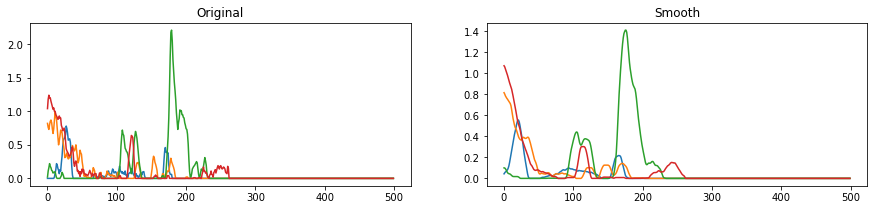

AU02 (outer brow raiser)


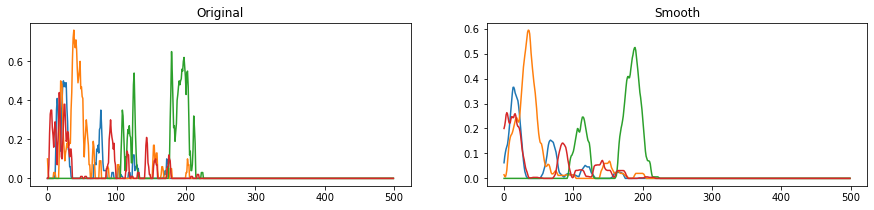

AU04 (brow lowerer)


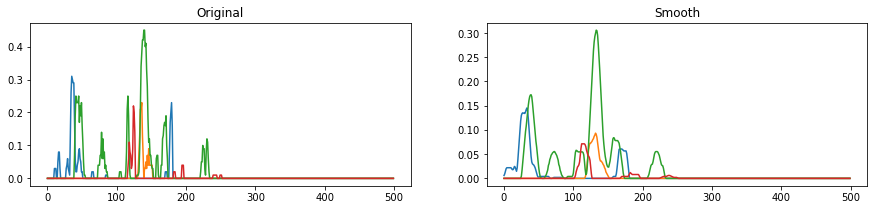

AU05 (upper lid raiser)


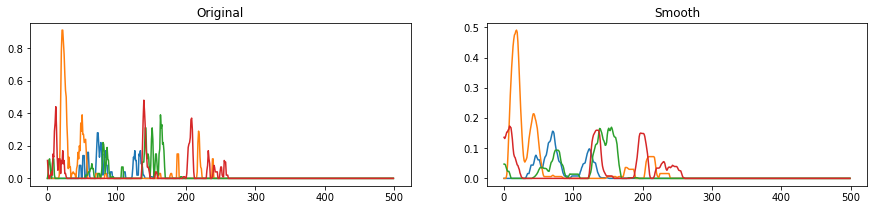

AU06 (cheek raiser)


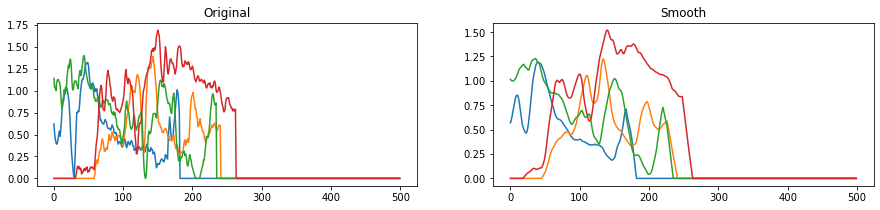

AU07 (lid tightener)


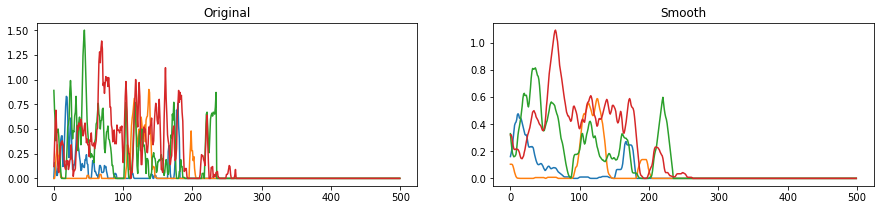

AU09 (nose wrinkler)


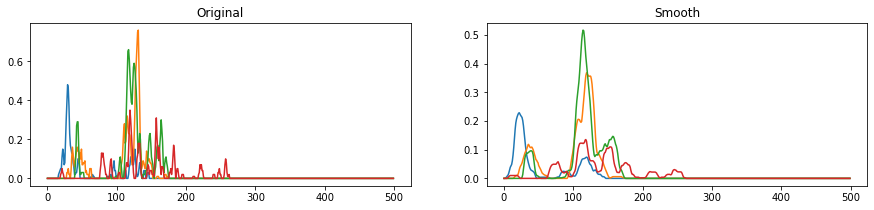

AU10 (upper lip raiser)


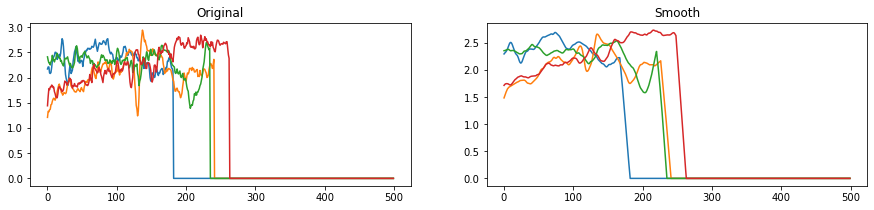

AU12 (lip corner puller)


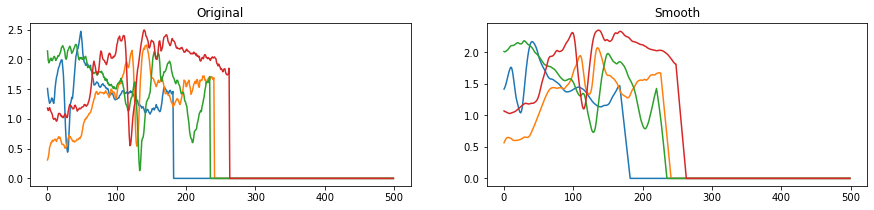

AU14 (dimpler)


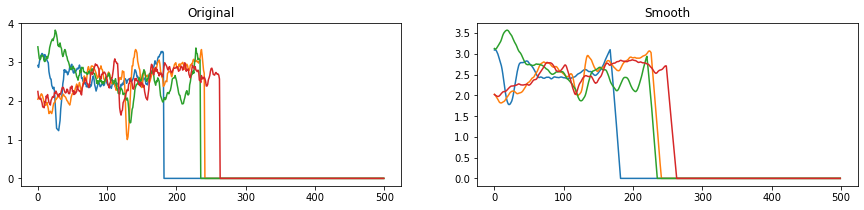

AU15 (lip corner depressor)


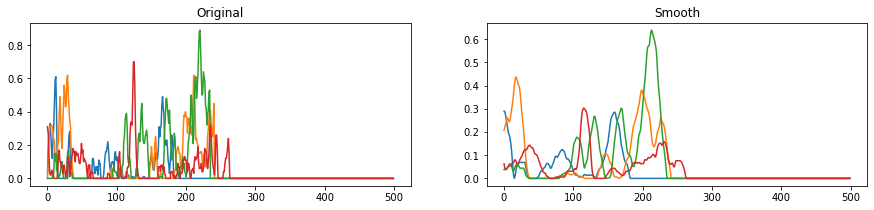

AU17 (chin raiser)


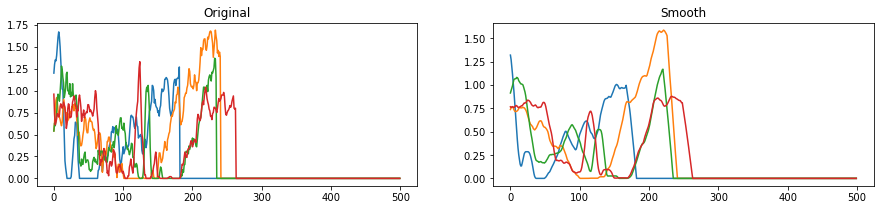

AU20 (lip stretcher)


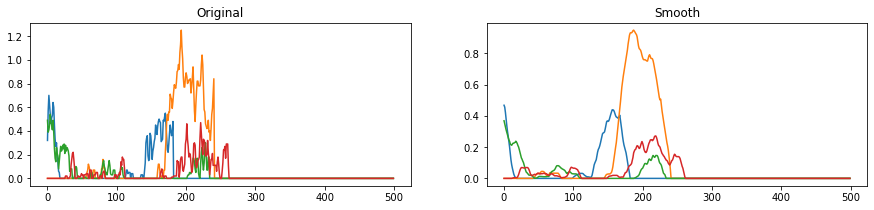

AU23 (lip tightener)


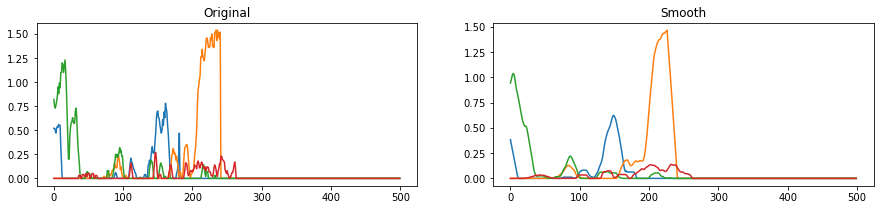

AU25 (lips part)


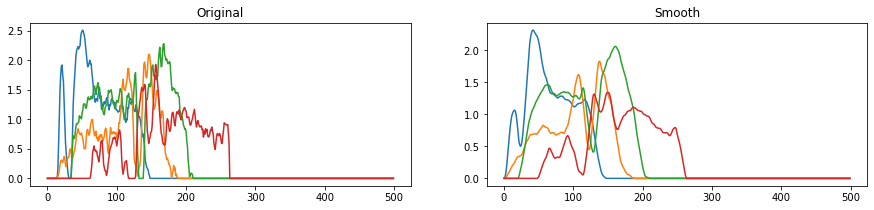

AU26 (jaw drop)


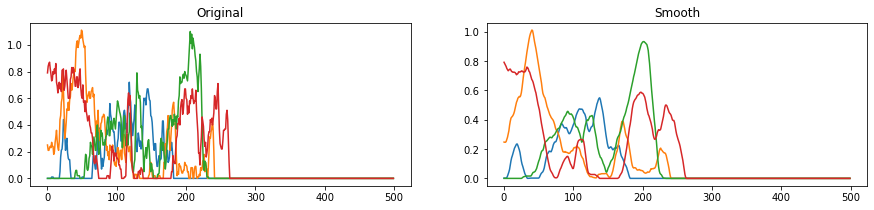

AU45 (blink)


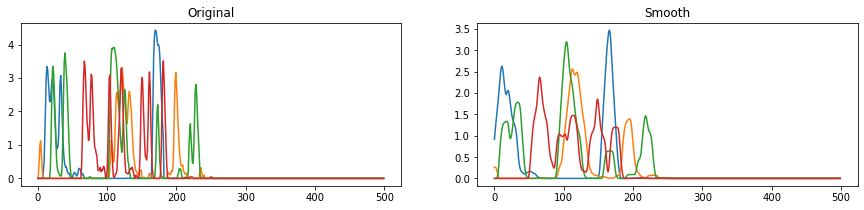

In [89]:
for au_idx, AU in enumerate(AU_INTENSITY_COLS):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    for vid_idx in range(4):
        axes[0].set_title("Original")
        axes[1].set_title("Smooth")
        ts = x[vid_idx, :500, au_idx]
        ts_smooth = x_smooth[vid_idx, :500, au_idx]
        axes[0].plot(ts)
        axes[1].plot(ts_smooth)
    print(au_intensity_name_to_desc[AU])
    plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_smooth, y, test_size=0.3)

In [11]:
X_train.shape

(246, 1082, 17)

In [87]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))

model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1082, 100)         47200     
_________________________________________________________________
flatten_5 (Flatten)          (None, 108200)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10820100  
_________________________________________________________________
dense_11 (Dense)             (None, 44)                4444      
Total params: 10,871,744
Trainable params: 10,871,744
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 13s 2s/step - loss: 4.6731 - accuracy: 0.0285 - val_loss: 4.1043 - val_accuracy: 0.0377
Epoch 2/60
5/5 [==============================] - 10s 2s/step - loss: 3.0168 - accuracy: 0.1911 - val_loss: 3.7088 - val_accuracy: 0.1132
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 2.2852 - accuracy: 0.3902 - val_loss: 3.7464 - val_accuracy: 0.0943
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 1.6290 - accuracy: 0.5935 - val_loss: 3.7917 - val_accuracy: 0.1604
Epoch 5/60
5/5 [==============================] - 10s 2s/step - loss: 1.0548 - accuracy: 0.7236 - val_loss: 3.8970 - val_accuracy: 0.1226
Epoch 6/60
5/5 [==============================] - 10s 2s/step - loss: 0.6232 - accuracy: 0.8659 - val_loss: 4.1282 - val_accuracy: 0.1415
Epoch 7/60
5/5 [==============================] - 10s 2s/step - loss: 0.3353 - accuracy: 0.9431 - val_loss: 4.7518 - val_accuracy: 0.1792
Epoch 8/60
5/5 [==================

KeyboardInterrupt: 

# Dropout layers

In [92]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation='relu'))

model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1082, 100)         47200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1082, 100)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 108200)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10820100  
_________________________________________________________________
dense_16 (Dense)             (None, 44)                4444      
Total params: 10,871,744
Trainable params: 10,871,744
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 13s 2s/step - loss: 4.3096 - accuracy: 0.0528 - val_loss: 4.1415 - val_accuracy: 0.0472
Epoch 2/60
5/5 [==============================] - 10s 2s/step - loss: 2.9747 - accuracy: 0.2398 - val_loss: 3.6789 - val_accuracy: 0.0755
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 2.1447 - accuracy: 0.4756 - val_loss: 3.8159 - val_accuracy: 0.0943
Epoch 4/60
5/5 [==============================] - 9s 2s/step - loss: 1.5524 - accuracy: 0.6057 - val_loss: 3.8475 - val_accuracy: 0.1509
Epoch 5/60
5/5 [==============================] - 10s 2s/step - loss: 1.0137 - accuracy: 0.7642 - val_loss: 3.8304 - val_accuracy: 0.1981
Epoch 6/60
5/5 [==============================] - 9s 2s/step - loss: 0.5905 - accuracy: 0.8902 - val_loss: 3.8731 - val_accuracy: 0.2453
Epoch 7/60
5/5 [==============================] - 9s 2s/step - loss: 0.2992 - accuracy: 0.9593 - val_loss: 4.1681 - val_accuracy: 0.2453
Epoch 8/60
5/5 [=====================

KeyboardInterrupt: 

In [94]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Dropout(0.5))
#model_d.add(TimeDistributed(Dense(100, activation='relu')))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1082, 100)         47200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1082, 100)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 108200)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 108200)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10820100  
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 44)               

In [95]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 12s 2s/step - loss: 3.9237 - accuracy: 0.0244 - val_loss: 3.5456 - val_accuracy: 0.0755
Epoch 2/60
5/5 [==============================] - 10s 2s/step - loss: 3.3214 - accuracy: 0.1423 - val_loss: 3.3974 - val_accuracy: 0.1038
Epoch 3/60
5/5 [==============================] - 10s 2s/step - loss: 2.9921 - accuracy: 0.1951 - val_loss: 3.4338 - val_accuracy: 0.1038
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 2.6141 - accuracy: 0.3211 - val_loss: 3.2912 - val_accuracy: 0.1509
Epoch 5/60
5/5 [==============================] - 10s 2s/step - loss: 2.1945 - accuracy: 0.3862 - val_loss: 3.2358 - val_accuracy: 0.1792
Epoch 6/60
5/5 [==============================] - 10s 2s/step - loss: 1.8687 - accuracy: 0.4553 - val_loss: 3.3457 - val_accuracy: 0.1509
Epoch 7/60
5/5 [==============================] - 10s 2s/step - loss: 1.7229 - accuracy: 0.4878 - val_loss: 3.5015 - val_accuracy: 0.1792
Epoch 8/60
5/5 [==================

KeyboardInterrupt: 

In [99]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=500,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Flatten())

model.add(Dense(100, activation='relu'))


model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1082, 500)         1036000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 541000)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               54100100  
_________________________________________________________________
dense_24 (Dense)             (None, 44)                4444      
Total params: 55,140,544
Trainable params: 55,140,544
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 14s 2s/step - loss: 6.8091 - accuracy: 0.0528 - val_loss: 4.4035 - val_accuracy: 0.0660
Epoch 2/60
5/5 [==============================] - 11s 2s/step - loss: 3.2410 - accuracy: 0.1748 - val_loss: 3.6878 - val_accuracy: 0.1604
Epoch 3/60
5/5 [==============================] - 11s 2s/step - loss: 2.1798 - accuracy: 0.4390 - val_loss: 3.7999 - val_accuracy: 0.1887
Epoch 4/60
5/5 [==============================] - 11s 2s/step - loss: 1.3802 - accuracy: 0.6098 - val_loss: 4.6250 - val_accuracy: 0.1604
Epoch 5/60
5/5 [==============================] - 11s 2s/step - loss: 0.8098 - accuracy: 0.8008 - val_loss: 5.0696 - val_accuracy: 0.1981
Epoch 6/60
5/5 [==============================] - 11s 2s/step - loss: 0.4245 - accuracy: 0.8821 - val_loss: 5.2687 - val_accuracy: 0.2075
Epoch 7/60
5/5 [==============================] - 11s 2s/step - loss: 0.2150 - accuracy: 0.9634 - val_loss: 5.9081 - val_accuracy: 0.1698
Epoch 8/60
5/5 [==================

In [12]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=50,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Flatten())

model.add(Dense(100, activation='relu'))


model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1082, 50)          13600     
_________________________________________________________________
flatten (Flatten)            (None, 54100)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               5410100   
_________________________________________________________________
dense_1 (Dense)              (None, 44)                4444      
Total params: 5,428,144
Trainable params: 5,428,144
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 12s 2s/step - loss: 4.0892 - accuracy: 0.0447 - val_loss: 3.9916 - val_accuracy: 0.0377
Epoch 2/60
5/5 [==============================] - 9s 2s/step - loss: 3.2041 - accuracy: 0.1870 - val_loss: 3.5737 - val_accuracy: 0.0849
Epoch 3/60
5/5 [==============================] - 9s 2s/step - loss: 2.6208 - accuracy: 0.3049 - val_loss: 3.7723 - val_accuracy: 0.0472
Epoch 4/60
5/5 [==============================] - 9s 2s/step - loss: 2.2252 - accuracy: 0.3496 - val_loss: 3.8353 - val_accuracy: 0.1415
Epoch 5/60
5/5 [==============================] - 9s 2s/step - loss: 1.6889 - accuracy: 0.5854 - val_loss: 3.9574 - val_accuracy: 0.1604
Epoch 6/60
5/5 [==============================] - 9s 2s/step - loss: 1.2782 - accuracy: 0.7317 - val_loss: 4.3230 - val_accuracy: 0.1415
Epoch 7/60
5/5 [==============================] - 9s 2s/step - loss: 0.9298 - accuracy: 0.8171 - val_loss: 4.4691 - val_accuracy: 0.1415
Epoch 8/60
5/5 [========================

KeyboardInterrupt: 

# Deeper 3 Layer LSTM

In [16]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(Dropout(0.2))


model.add(LSTM(units=100,
              return_sequences=True))

model.add(Dropout(0.2))


model.add(LSTM(units=100,
              return_sequences=True))

model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(100, activation='relu'))


model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1082, 100)         47200     
_________________________________________________________________
dropout (Dropout)            (None, 1082, 100)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1082, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1082, 100)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1082, 100)         80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1082, 100)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 108200)           

In [17]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 42s 7s/step - loss: 3.7148 - accuracy: 0.0488 - val_loss: 3.7271 - val_accuracy: 0.0566
Epoch 2/60
5/5 [==============================] - 34s 7s/step - loss: 2.9484 - accuracy: 0.1911 - val_loss: 3.8144 - val_accuracy: 0.0660
Epoch 3/60
5/5 [==============================] - 33s 7s/step - loss: 2.0246 - accuracy: 0.4675 - val_loss: 4.0948 - val_accuracy: 0.1887
Epoch 4/60
5/5 [==============================] - 33s 7s/step - loss: 1.1647 - accuracy: 0.7114 - val_loss: 4.8680 - val_accuracy: 0.1604
Epoch 5/60
5/5 [==============================] - 33s 7s/step - loss: 0.6066 - accuracy: 0.8333 - val_loss: 5.7143 - val_accuracy: 0.1792
Epoch 6/60
5/5 [==============================] - 32s 7s/step - loss: 0.2965 - accuracy: 0.9350 - val_loss: 6.3668 - val_accuracy: 0.1792
Epoch 7/60
5/5 [==============================] - 33s 7s/step - loss: 0.1340 - accuracy: 0.9593 - val_loss: 7.6460 - val_accuracy: 0.1792
Epoch 8/60
5/5 [==================

KeyboardInterrupt: 

In [18]:
seq_len=1082
STEPS = 50
EPOCHS= 60

model = Sequential()

model.add(LSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,17)))

model.add(LSTM(units=100,
              return_sequences=True))

model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(100, activation='relu'))


model.add(Dense(44, activation='sigmoid'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1082, 100)         47200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1082, 100)         80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1082, 100)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 108200)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10820100  
_________________________________________________________________
dense_7 (Dense)              (None, 44)                4444      
Total params: 10,952,144
Trainable params: 10,952,144
Non-trainable params: 0
__________________________________________

In [19]:
model.fit(X_train, y_train, batch_size=50, epochs=EPOCHS, validation_data=(X_test, y_test))

Epoch 1/60
5/5 [==============================] - 25s 4s/step - loss: 3.7570 - accuracy: 0.0650 - val_loss: 3.4605 - val_accuracy: 0.0566
Epoch 2/60
5/5 [==============================] - 21s 4s/step - loss: 2.8083 - accuracy: 0.2358 - val_loss: 3.1492 - val_accuracy: 0.1226
Epoch 3/60
5/5 [==============================] - 21s 4s/step - loss: 1.9734 - accuracy: 0.4837 - val_loss: 3.2439 - val_accuracy: 0.1604
Epoch 4/60
5/5 [==============================] - 21s 4s/step - loss: 1.2440 - accuracy: 0.6707 - val_loss: 3.4562 - val_accuracy: 0.1981
Epoch 5/60
5/5 [==============================] - 21s 4s/step - loss: 0.6425 - accuracy: 0.8415 - val_loss: 4.2410 - val_accuracy: 0.2264
Epoch 6/60
5/5 [==============================] - 21s 4s/step - loss: 0.3385 - accuracy: 0.8943 - val_loss: 5.1405 - val_accuracy: 0.1981
Epoch 7/60
5/5 [==============================] - 20s 4s/step - loss: 0.2348 - accuracy: 0.9228 - val_loss: 5.5924 - val_accuracy: 0.2075
Epoch 8/60
5/5 [==================

KeyboardInterrupt: 